## Imports 

In [1]:
!pip install dm-sonnet dm-tree
!git clone https://github.com/Dino1G/SCC413.git # Connect to github
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.metrics import mean_squared_error
import pandas as pd
from keras import backend as K
try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 KB 6.1 MB/s eta 0:00:00
Cloning into 'SCC413'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 391 (delta 0), reused 91 (delta 0), pack-reused 300
Receiving objects: 100% (391/391), 2.87 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
print(tf.__version__)
print(snt.__version__)

2.11.0
2.0.1


## Data Pre-processing

In [3]:
# Set the path to the image folder
folder_paths = ["/content/SCC413/CUHK_testing_cropped_photos",
               "/content/SCC413/CUHK_training_cropped_photos"]

# Set the size of the crop
crop_width = 200
crop_height = 200

# Faces
Faces = []
# Loop through the files in the folder
for folder_path in folder_paths:
    for file_name in sorted(os.listdir(folder_path)):
        # Check if the file is an image file
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            # Open the image file
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            image = image.convert("RGB")

            # Get the width and height of the image
            width, height = image.size

            # Calculate the coordinates of the top-left corner of the crop
            crop_x = (width - crop_width) // 2
            crop_y = (height - crop_height) // 2

            # Crop the image to the desired size
            cropped_image = image.crop((crop_x, crop_y, crop_x + crop_width, crop_y + crop_height))
            image_array = np.asarray(cropped_image)
            Faces.append(image_array)

folder_paths = ["/content/SCC413/CUHK_testing_cropped_sketches",
               "/content/SCC413/CUHK_training_cropped_sketches"]
# Sketches
Sketches = []
# Loop through the files in the folder
for folder_path in folder_paths:
    for file_name in sorted(os.listdir(folder_path)):
        # Check if the file is an image file
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            # Open the image file
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path)
            image = image.convert("RGB")

            # Get the width and height of the image
            width, height = image.size

            # Calculate the coordinates of the top-left corner of the crop
            crop_x = (width - crop_width) // 2
            crop_y = (height - crop_height) // 2

            # Crop the image to the desired size
            cropped_image = image.crop((crop_x, crop_y, crop_x + crop_width, crop_y + crop_height))
            image_array = np.asarray(cropped_image)
            Sketches.append(image_array)

# Split the data into training and test sets
Faces_train, Faces_test, Sketches_train, Sketches_test = train_test_split(np.array(Faces), np.array(Sketches), test_size=0.2, random_state=3)
Faces_train = Faces_train.astype('float32') / 255.
Faces_test = Faces_test.astype('float32') / 255.
Sketches_train = Sketches_train.astype('float32') / 255.
Sketches_test = Sketches_test.astype('float32') / 255.
print(len(Faces_train))
print(len(Faces_test))

150
38


### Check if faces and sketches are match

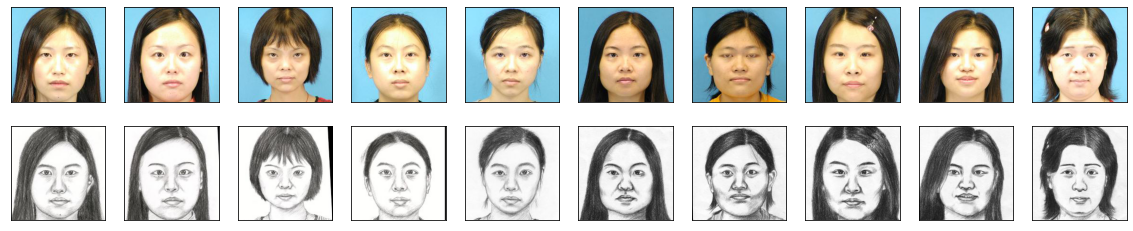

In [4]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display Faces
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Faces[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Sketches
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(Sketches[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Model 1: Deep Autoencoder (DAE)

Epoch 1/1000
2/2 [==============================] - 11s 468ms/step - loss: 0.6928 - val_loss: 0.5937
Epoch 2/1000
2/2 [==============================] - 0s 207ms/step - loss: 0.5769 - val_loss: 0.4531
Epoch 3/1000
2/2 [==============================] - 0s 146ms/step - loss: 0.4463 - val_loss: 0.4444
Epoch 4/1000
2/2 [==============================] - 0s 173ms/step - loss: 0.4412 - val_loss: 0.4322
Epoch 5/1000
2/2 [==============================] - 0s 241ms/step - loss: 0.4271 - val_loss: 0.4194
Epoch 6/1000
2/2 [==============================] - 0s 140ms/step - loss: 0.4147 - val_loss: 0.4155
Epoch 7/1000
2/2 [==============================] - 0s 250ms/step - loss: 0.4117 - val_loss: 0.4153
Epoch 8/1000
2/2 [==============================] - 0s 231ms/step - loss: 0.4103 - val_loss: 0.4147
Epoch 9/1000
2/2 [==============================] - 0s 210ms/step - loss: 0.4079 - val_loss: 0.4155
Epoch 10/1000
2/2 [==============================] - 0s 228ms/step - loss: 0.4064 - val_loss: 0.414

Text(0, 0.5, 'Training Error')

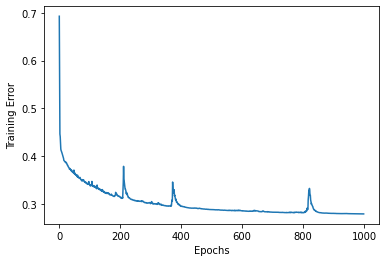

In [5]:
X_train = Faces_train.reshape((len(Faces_train), np.prod(Faces_train.shape[1:])))
X_test = Faces_test.reshape((len(Faces_test), np.prod(Faces_test.shape[1:])))
Y_train = Sketches_train.reshape((len(Sketches_train), np.prod(Sketches_train.shape[1:])))
Y_test = Sketches_test.reshape((len(Sketches_test), np.prod(Sketches_test.shape[1:])))

# define a 3+3 deep autoencoder
input_img = keras.Input(shape=(200*200*3,))
encoded = keras.layers.Dense(128, activation='relu')(input_img)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(200*200*3, activation='sigmoid')(decoded)


model_DAE = keras.Model(input_img, decoded)
model_DAE.compile(optimizer='adam', loss='binary_crossentropy')

hist_DAE = model_DAE.fit(X_train, Y_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, Y_test))

plt.plot(hist_DAE.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Training Error')


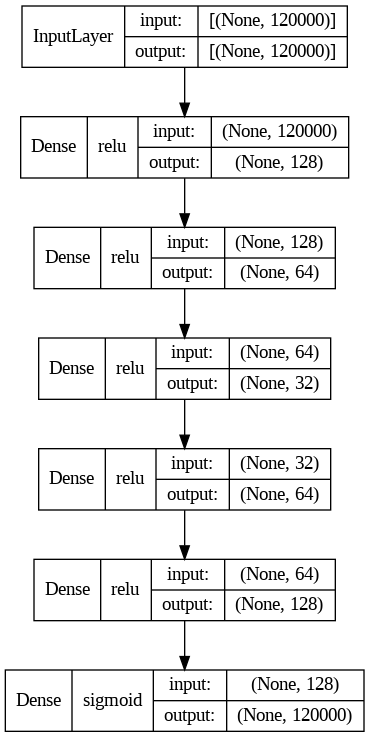

In [6]:
dot_img_file = '/tmp/model_DAE.png'
tf.keras.utils.plot_model(model_DAE, to_file=dot_img_file, show_shapes=True, show_layer_activations=True,show_layer_names=False)


2/2 [==============================] - 0s 11ms/step


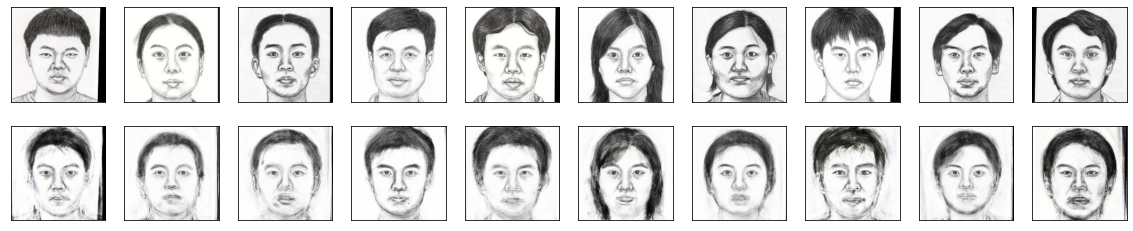

In [7]:
recon_DAE = model_DAE.predict(X_test)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Y_test[i].reshape(200,200,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_DAE[i].reshape(200,200,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Model 2:Variational Autoencoder (VAE)

Epoch 1/1000
2/2 [==============================] - 2s 252ms/step - loss: 114580.6016 - val_loss: 80724.3984
Epoch 2/1000
2/2 [==============================] - 0s 81ms/step - loss: 77146.6562 - val_loss: 71168.6016
Epoch 3/1000
2/2 [==============================] - 0s 68ms/step - loss: 70305.5234 - val_loss: 69104.9141
Epoch 4/1000
2/2 [==============================] - 0s 72ms/step - loss: 68659.3281 - val_loss: 68625.7109
Epoch 5/1000
2/2 [==============================] - 0s 109ms/step - loss: 68380.1562 - val_loss: 68186.2422
Epoch 6/1000
2/2 [==============================] - 0s 87ms/step - loss: 67584.4062 - val_loss: 67976.4609
Epoch 7/1000
2/2 [==============================] - 0s 73ms/step - loss: 67325.8906 - val_loss: 67733.7891
Epoch 8/1000
2/2 [==============================] - 0s 105ms/step - loss: 67348.0469 - val_loss: 67704.4922
Epoch 9/1000
2/2 [==============================] - 0s 141ms/step - loss: 66669.0156 - val_loss: 67462.5625
Epoch 10/1000
2/2 [=============

Text(0, 0.5, 'Training Error')

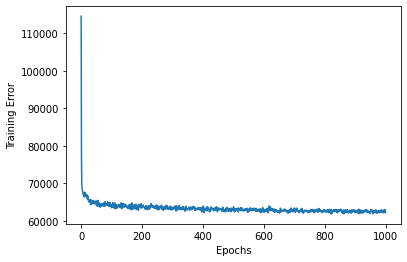

In [17]:
original_dim = 200 * 200 * 3
intermediate_dim = 128
latent_dim = 4

inputs = keras.Input(shape=(original_dim,))
h = keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = keras.layers.Dense(latent_dim)(h)
z_log_sigma = keras.layers.Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling)([z_mean, z_log_sigma])
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = keras.layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
model_VAE = keras.Model(inputs, outputs, name='vae_mlp')
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
model_VAE.add_loss(vae_loss)
model_VAE.compile(optimizer='adam')

X_train = Faces_train.reshape((len(Faces_train), np.prod(Faces_train.shape[1:])))
X_test = Faces_test.reshape((len(Faces_test), np.prod(Faces_test.shape[1:])))
Y_train = Sketches_train.reshape((len(Sketches_train), np.prod(Sketches_train.shape[1:])))
Y_test = Sketches_test.reshape((len(Sketches_test), np.prod(Sketches_test.shape[1:])))

hist_VAE = model_VAE.fit(X_train, Y_train,
        epochs=1000,
        batch_size=128,
        validation_data=(X_test, Y_test))

plt.plot(hist_VAE.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Training Error')

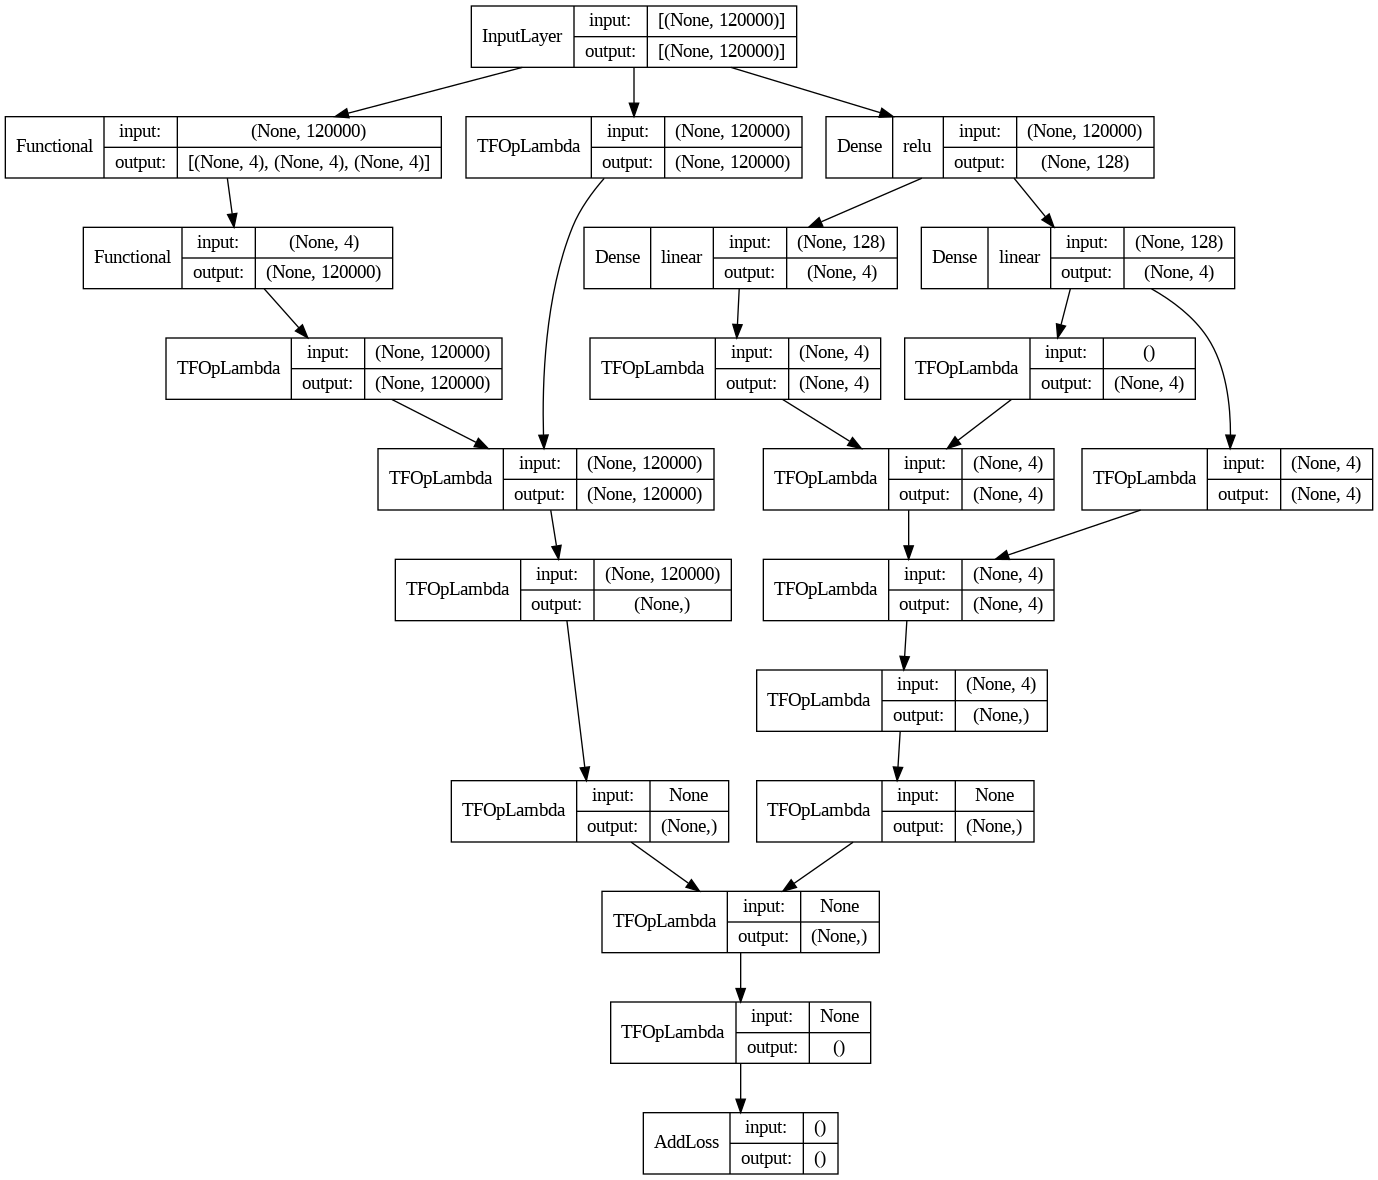

In [18]:
dot_img_file = '/tmp/model_VAE.png'
tf.keras.utils.plot_model(model_VAE, to_file=dot_img_file, show_shapes=True, show_layer_activations=True,show_layer_names=False)


2/2 [==============================] - 0s 6ms/step


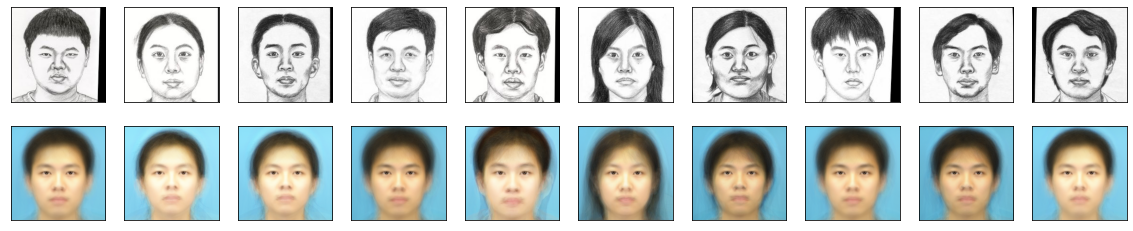

In [19]:
recon_VAE = model_VAE.predict(X_test)
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Y_test[i].reshape(200,200,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_VAE[i].reshape(200,200,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Model 3: Convolutional Autoencoder with Self-Attention and Quantization (CASQ)

In [20]:
# Parameters
embedding_dim = 16
num_embeddings = 128
commitment_cost = 0.25

# Define quantized layer
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
vq_vae = snt.nets.VectorQuantizer(
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost)

Epoch 1/1000
2/2 [==============================] - 16s 2s/step - loss: 0.6945 - val_loss: 0.6568
Epoch 2/1000
2/2 [==============================] - 1s 158ms/step - loss: 0.6540 - val_loss: 0.6083
Epoch 3/1000
2/2 [==============================] - 1s 156ms/step - loss: 0.6060 - val_loss: 0.5518
Epoch 4/1000
2/2 [==============================] - 1s 156ms/step - loss: 0.5518 - val_loss: 0.5333
Epoch 5/1000
2/2 [==============================] - 1s 152ms/step - loss: 0.5406 - val_loss: 0.5545
Epoch 6/1000
2/2 [==============================] - 1s 156ms/step - loss: 0.5606 - val_loss: 0.5382
Epoch 7/1000
2/2 [==============================] - 1s 154ms/step - loss: 0.5431 - val_loss: 0.5253
Epoch 8/1000
2/2 [==============================] - 1s 153ms/step - loss: 0.5300 - val_loss: 0.5297
Epoch 9/1000
2/2 [==============================] - 1s 151ms/step - loss: 0.5337 - val_loss: 0.5341
Epoch 10/1000
2/2 [==============================] - 1s 156ms/step - loss: 0.5371 - val_loss: 0.5306
E

Text(0, 0.5, 'Training Error')

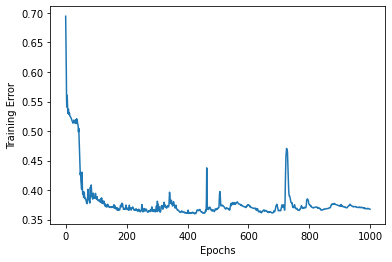

In [21]:
# Parameters
embedding_dim = 32
num_embeddings = 128
commitment_cost = 0.25

# Define quantized layer
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")
vq_vae = snt.nets.VectorQuantizer(
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost)
# Define the CASQ architecture
input_img = keras.Input(shape=(200, 200, 3))
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

attention = tf.keras.layers.Attention()([encoded, encoded])
z = pre_vq_conv1(attention)
vq_output = vq_vae(z, is_training=True)

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(vq_output['quantize'])
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the model
model_CASQ = keras.Model(input_img, decoded)

# Compile the model
model_CASQ.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
hist_CASQ = model_CASQ.fit(Faces_train, Sketches_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(Faces_test, Sketches_test))

plt.plot(hist_CASQ.history["loss"])
plt.xlabel('Epochs')
plt.ylabel('Training Error')


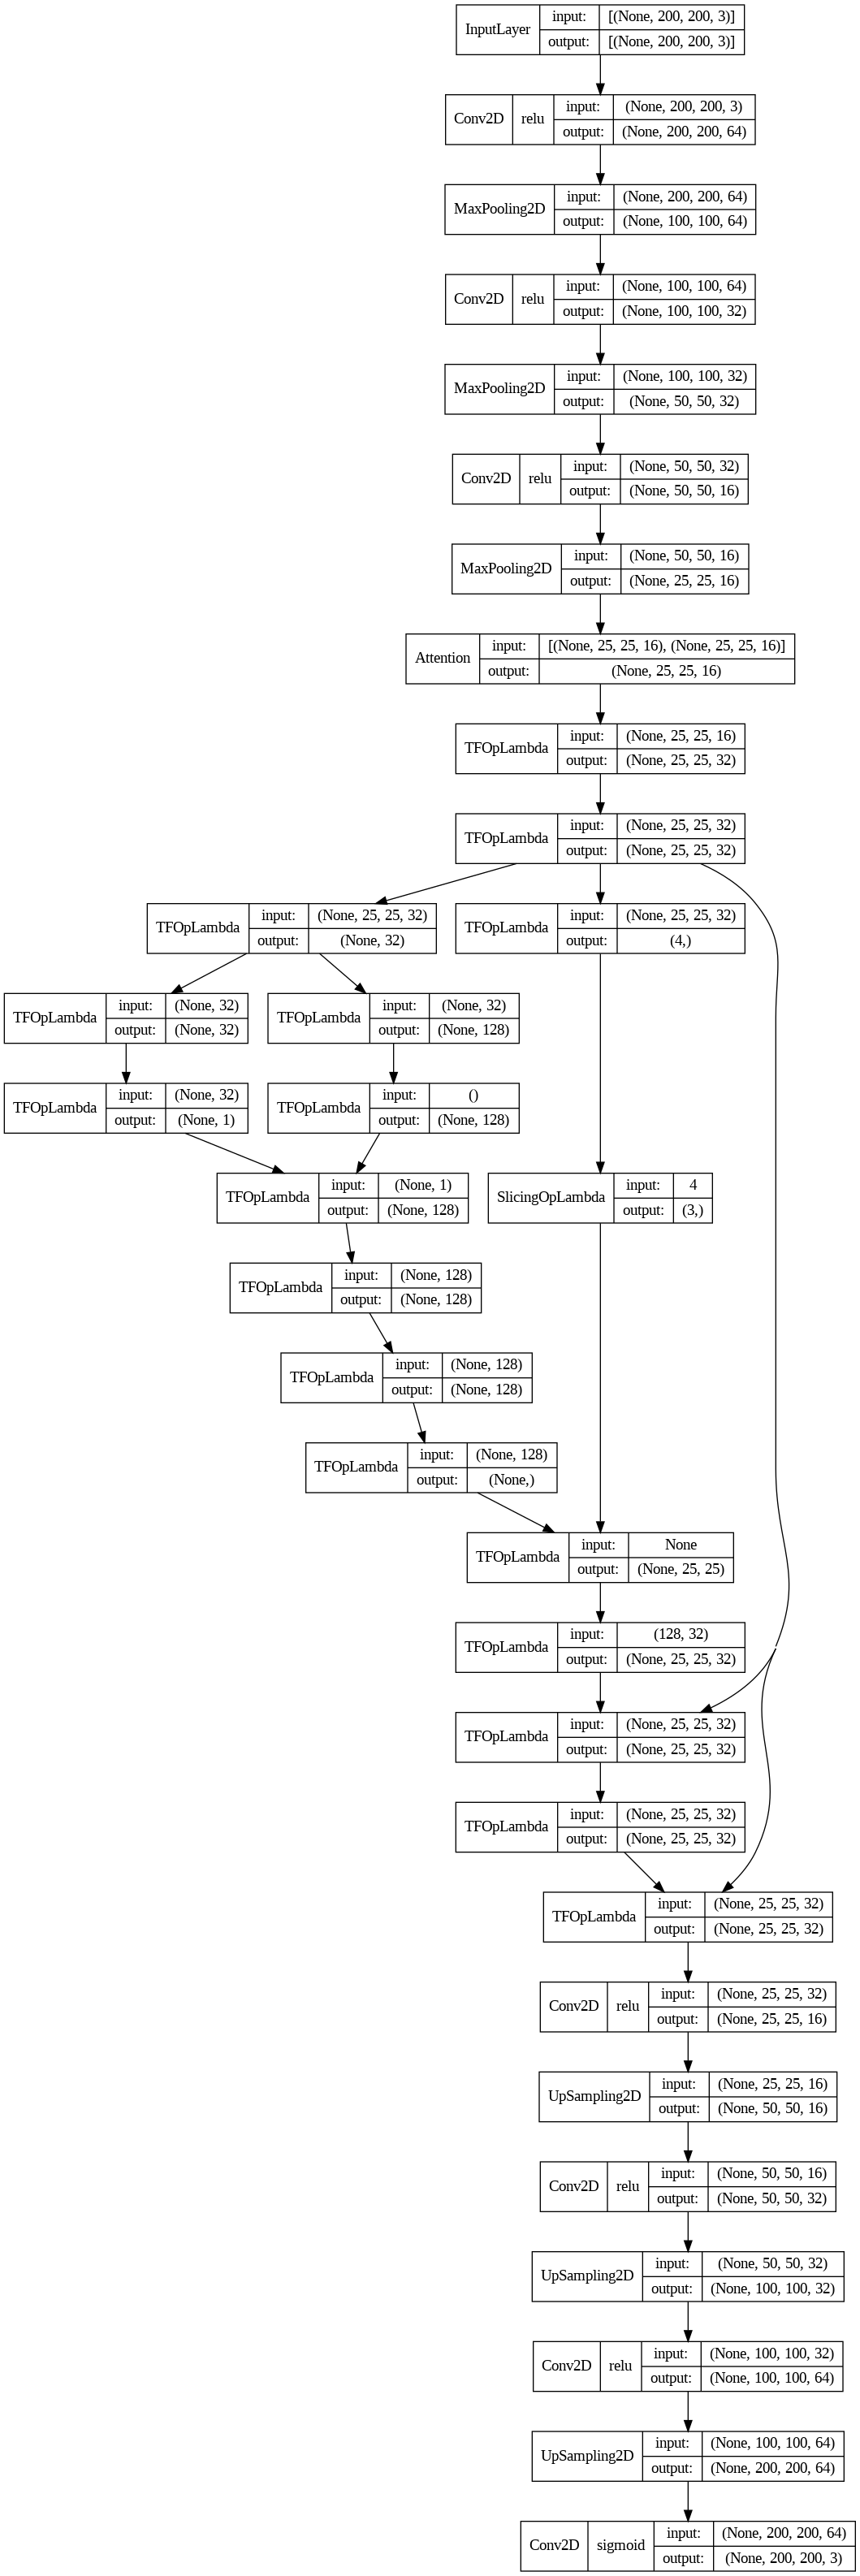

In [22]:
dot_img_file = '/tmp/model_CASQ.png'
tf.keras.utils.plot_model(model_CASQ, to_file=dot_img_file, show_shapes=True, show_layer_activations=True,show_layer_names=False)


2/2 [==============================] - 1s 257ms/step


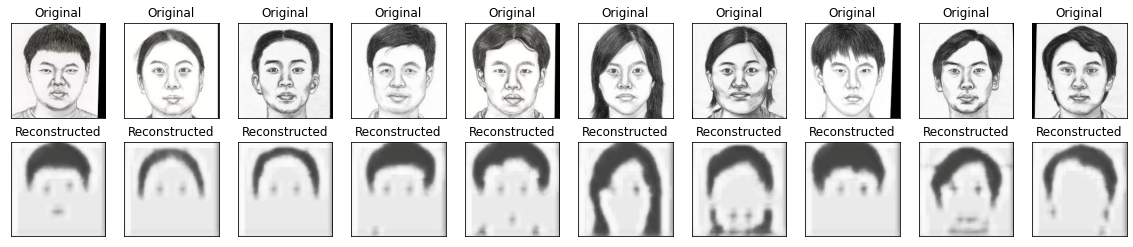

In [23]:
# Predict the reconstructed images for a test set
recon_CASQ = model_CASQ.predict(Faces_test)

# Plot the original and reconstructed images side by side
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Sketches_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(recon_CASQ[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Measurement (SSIM & MSE)

In [24]:
recon_DAE = recon_DAE.reshape(38, 200, 200, 3)
recon_VAE = recon_VAE.reshape(38, 200, 200 ,3)
ssim_DAE = tf.image.ssim(Sketches_test, recon_DAE, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
ssim_VAE = tf.image.ssim(Sketches_test, recon_VAE, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
ssim_CASQ = tf.image.ssim(Sketches_test, recon_CASQ, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)

In [25]:
# Calculate the mean squared error between the two images
mse_DAE = mean_squared_error(Sketches_test, recon_DAE)
mse_VAE = mean_squared_error(Sketches_test, recon_VAE)
mse_CASQ = mean_squared_error(Sketches_test, recon_CASQ)



In [27]:
data = {'DAE': [mse_DAE, np.mean(ssim_DAE)],
        'VAE': [mse_VAE, np.mean(ssim_VAE)],
        'CASQ': [mse_CASQ, np.mean(ssim_CASQ)]}
index = ['MSE', 'SSIM']
df = pd.DataFrame(data=data, index=index)
df


,DAE,VAE,CASQ
MSE,0.049908,0.099079,0.031974
SSIM,0.471451,0.470112,0.528875
